In [1]:
import torch
import os
import io
import sys
import csv
import six
# from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import warnings ; warnings.filterwarnings('ignore') 
import itertools
import collections
import argparse

from torchtext.vocab import Vectors, Vocab
import gensim
from collections import defaultdict, OrderedDict

from model import IQN
from trainer import Trainer
from utils import MyDataset
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline

In [2]:
parser = argparse.ArgumentParser(description=None)
parser.add_argument('-e', '--env', default='PongNoFrameskip-v4', type=str, help='gym environment')
parser.add_argument('-d', '--density', default=1, type=int, help='density of grid of gaussian blurs')
parser.add_argument('-r', '--radius', default=5, type=int, help='radius of gaussian blur')
parser.add_argument('-f', '--num_frames', default=100, type=int, help='number of frames in movie')
parser.add_argument('-i', '--first_frame', default=150, type=int, help='index of first frame')
parser.add_argument('-dpi', '--resolution', default=75, type=int, help='resolution (dpi)')
parser.add_argument('-s', '--save_dir', default='./movies/', type=str,
                    help='dir to save agent logs and checkpoints')
parser.add_argument('-p', '--prefix', default='default', type=str, help='prefix to help make video name unique')
parser.add_argument('-c', '--checkpoint', default='*.tar', type=str,
                    help='checkpoint name (in case there is more than one')
parser.add_argument('-o', '--overfit_mode', default=False, type=bool,
                    help='analyze an overfit environment (see paper)')

# text parameter
parser.add_argument('--max_length', type=int, default=64)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--target_update_freq', type=int, default=100)
parser.add_argument('--evaluation_freq', type=int, default=10)
parser.add_argument('--network_save_freq', type=int, default=100)
parser.add_argument('--num_actions', type=int, default=1)

parser.add_argument('--min_freq', type=int, default=10)
parser.add_argument('--embedding_dim', type=int, default=300)
parser.add_argument('--n_filters', type=int, default=50)
parser.add_argument('--filter_sizes', type=list, default=[3, 4, 5])
parser.add_argument('--pad_idx', type=list, default=1)
parser.add_argument('--gamma', type=float, default=0.0)
parser.add_argument('--learning_rate', type=float, default=2.5e-5)
parser.add_argument('--round', type=float, default=0)

parser.add_argument('--num_quantile', type=int, default=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser.add_argument('--device', type=str, default=device)

args = parser.parse_args(args=[])

args.rnn = False

In [3]:
japanese_vectors = Vectors(name='../data/news/cc.ja.300.vec')

# Create Dataset
train_ds = MyDataset(
    path=os.path.join('..', 'data', 'news', 'text_train.tsv'),
    specials=['<company>', '<organization>', '<person>', '<location>'],
    max_len=args.max_length,
    vectors=japanese_vectors,
    min_freq=args.min_freq,
    phase='train'
)

test_ds = MyDataset(
    path=os.path.join('..', 'data', 'news', 'text_test.tsv'),
    max_len=args.max_length,
    vocab=train_ds.vocab,
    min_freq=args.min_freq,
    phase='val'
)

train_dl = torch.utils.data.DataLoader(
    train_ds, 
    batch_size = 1, 
    shuffle = False
)

test_dl = torch.utils.data.DataLoader(
    test_ds, 
    batch_size = 1,
    shuffle = False
)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

text_vectors = train_ds.vocab.vectors
vocab_size = len(train_ds.vocab.vectors)
model = IQN(text_vectors, vocab_size, args.embedding_dim, args.n_filters,
                         args.filter_sizes, args.pad_idx,
                         n_actions=args.num_actions,
                         n_quant=args.num_quantile,
                         rnn=args.rnn)

model = model.to(device)

trainer = Trainer(args, text_vectors, vocab_size, train_dl)
trainer.load_model()
trainer.model.eval()

IQN(
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (embedding): Embedding(1493, 300)
  (phi): Linear(in_features=64, out_features=64, bias=True)
  (cnn): CNN(
    (convs): ModuleList(
      (0): Conv2d(1, 50, kernel_size=(3, 300), stride=(1, 1))
      (1): Conv2d(1, 50, kernel_size=(4, 300), stride=(1, 1))
      (2): Conv2d(1, 50, kernel_size=(5, 300), stride=(1, 1))
    )
    (fc0): Linear(in_features=150, out_features=64, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (rnn): RNN(
    (lstm): LSTM(300, 50, batch_first=True, bidirectional=True)
    (attn): Attn(
      (fc): Sequential(
        (0): Linear(in_features=50, out_features=24, bias=True)
        (1): ReLU(inplace=True)
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=24, out_features=1, bias=True)
      )
    )
    (fc0): Linear(in_features=50, out_features=64, bias=True)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_featu

In [5]:
eta0 = 0
eta1 = 1
std_list = []
for i, batch in enumerate(train_dl):
    with torch.no_grad():
        state = batch['State'].to(device)
        reward = batch['Reward']
        curr_q, _, _ = trainer.model(state, eta0, eta1, True)
    std = curr_q.view(-1).std().cpu().detach().item()
    std_list.append(std)
    if std > 6:
        state = state.view(-1).cpu().numpy()
#         print('i: ', str(i), '   ')
        for word in state:
            vocab = train_ds.vocab.itos[word]
            if (vocab == '<pad>') or (vocab == '<unk>'):
                continue
            print(vocab+' ', end='')
        print(' ' + str(np.round(reward.item(), 3)), end='')
        print()

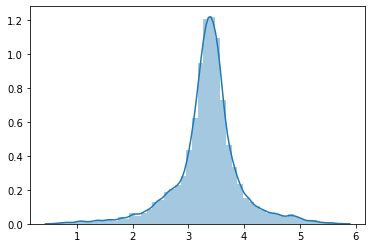

In [6]:
sns.distplot(std_list)

In [7]:
eta0 = 0
eta1 = 1
std_list = []
for i, batch in enumerate(test_dl):
    with torch.no_grad():
        state = batch['State'].to(device)
        reward = batch['Reward']
        curr_q, _, _ = trainer.model(state, eta0, eta1, True)
    std = curr_q.view(-1).std().cpu().detach().item()
    std_list.append(std)
    if std > 6:
        print('i: ', str(i), '   ')
        state = state.view(-1).cpu().numpy()
        for word in state:
            vocab = train_ds.vocab.itos[word]
            if (vocab == '<pad>') or (vocab == '<unk>'):
                continue
            print(vocab+' ', end='')
        print(' ' + str(np.round(reward.item(), 3)), end='')
        print()

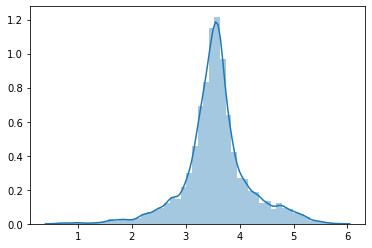

In [8]:
sns.distplot(std_list)

In [9]:
states = []
rewards = []
for batch in test_dl:
    states.append(batch['State'].numpy()[0])
    rewards.append(batch['Reward'].numpy()[0])

states = np.array(states)
rewards = np.array(rewards)

In [10]:
# HTMLを作成する関数を実装
def highlight(word, attn):
    "Attentionの値が大きいと文字の背景が濃い赤になるhtmlを出力させる関数"

    if attn >= 0:
        html_color = '#%02X%02X%02X' % (
            255, int(255*(1 - attn)), int(255*(1 - attn)))
    else:
        html_color = '#%02X%02X%02X' % (
            int(255*(1 - attn)), 255, int(255*(1 - attn)))
    return '<span style="background-color: {}"> {}</span>'.format(html_color, word)

def mk_html(sentence, attens):
    # 表示用のHTMLを作成する
    html = ""
    # 1段目のAttention
    html += '<br>'
    for word, attn in zip(sentence, attens):
        word = train_ds.vocab.itos[word]
        if word[0] == '<':
            word = word[1:-1]
            if (word == 'pad') or (word=='unk'):
                continue
        html += highlight(word, attn)
    html += "<br><br>"

    return html

def blur_func(I, mask):
    return I * mask

reward:  2.162546 mean:  0.065545976 median:  -0.023129959 std:  3.1515536 sr:  0.020797988


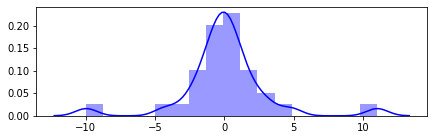

In [16]:
idx = 1376
eta0 = 0
eta1 = 1

sentence = states[idx]
state = torch.LongTensor(sentence).to(device).unsqueeze(0)

# 1次元maskの作成
mask = np.zeros((1*args.max_length, args.max_length)).astype(np.int8)

for j in range(args.max_length):
    circle = np.ones([args.max_length])
    if (sentence[j] == 0) or (sentence[j] == 1) \
            or (sentence[j] == 2) or (sentence[j] == 3):
        circle[j] = 1
    else:
        circle[j] = 0
    mask[j] = circle.astype(np.int8)

# ネットワークの出力を得る
with torch.no_grad():
    curr_q, _, _ = trainer.model(state, eta0, eta1, True)
    L = curr_q.mean()

# 各ピクセルにマスクする
masked_sentence = blur_func(sentence, mask)

# ノイズを入れたデータの出力を得る
state = torch.LongTensor(masked_sentence).to(device)
state = state.view(-1, args.max_length)
with torch.no_grad():
    masked_curr_q, _, _ = trainer.model(state, eta0, eta1, True)
    l = masked_curr_q.mean(axis=1)

pad_mask = np.ones([args.max_length])
for j in range(args.max_length):
    if (sentence[j] == 0) or (sentence[j] == 1) \
            or (sentence[j] == 2) or (sentence[j] == 3):
        pad_mask[j] = 0

# スコアを記憶する配列
scores = np.zeros(args.max_length)   # saliency scores S(t,i,j)

for j in range(0, args.max_length):
    # d=5としてその部分を描画する
    scores[j] = (L-l[j]).pow(2).sum().mul_(.5).item()
#     scores[j] = (L-l[j]).sum().item()

scores = scores * pad_mask
saliency = scores / (np.abs(scores).max() + 1e-20)


fig, ax = plt.subplots(1, figsize=(7, 2));
sns.distplot(curr_q.view(-1).cpu().numpy(), color='blue', ax=ax)

print('reward: ', rewards[idx], 
          'mean: ', np.mean(curr_q.view(-1).cpu().numpy()),
          'median: ', np.median(curr_q.view(-1).cpu().numpy()),
          'std: ', np.std(curr_q.view(-1).cpu().numpy()),
          'sr: ', np.mean(curr_q.view(-1).cpu().numpy()) / np.std(curr_q.view(-1).cpu().numpy()))

html_output = mk_html(states[idx], saliency)
HTML(html_output)